In [3]:
# Baseline model, doing logistic regression on the data
# Import pandas and sklearn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder


/var/folders/dh/k98322pj6lvbxs4484w64fsw0000gn/T/ipykernel_91313/94502708.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df = pd.read_csv('data/train.csv')

# Split the data into training and testing data
# X = df.drop(['Exited', 'Surname', 'CustomerId', 'Gender', 'Geography'], axis=1)
df['SurnameLen'] = df['Surname'].apply(lambda x: len(x))
X = df.drop(['Exited', 'Surname', 'CustomerId'], axis=1)

In [5]:
X.describe()

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,SurnameLen
count,165034.0000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,6.543179
std,47641.3565,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,2.614270
min,0.0000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,2.000000
25%,41258.2500,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,5.000000
50%,82516.5000,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,6.000000
75%,123774.7500,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,8.000000
max,165033.0000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,23.000000


In [6]:
# # one-hot encode the categorical variables (gender, geography)
# enc = OneHotEncoder(handle_unknown='ignore')
# X = enc.fit_transform(X).toarray()


In [7]:
# Describe the X dataframe
# pd.DataFrame(X).describe()

In [8]:
y = df['Exited']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Define column names for categorical and numeric columns
columns_to_drop = ['CustomerId']
categorical_columns = ['Gender', 'Geography']
numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                   'EstimatedSalary']

# Create the column preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(categories='auto'), categorical_columns),
        ('std_scaler', StandardScaler(), numeric_columns)
    ])

# Create the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

# Fit the pipeline to the data
pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['Gender', 'Geography']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary'])])),
                ('log_reg', LogisticRegression())])

In [11]:
# Classes
pipe[:-1].get_feature_names_out()

array(['ohe__Gender_Female', 'ohe__Gender_Male', 'ohe__Geography_France',
       'ohe__Geography_Germany', 'ohe__Geography_Spain',
       'std_scaler__CreditScore', 'std_scaler__Age', 'std_scaler__Tenure',
       'std_scaler__Balance', 'std_scaler__NumOfProducts',
       'std_scaler__HasCrCard', 'std_scaler__IsActiveMember',
       'std_scaler__EstimatedSalary'], dtype=object)

In [13]:
# Make predictions
y_pred = pipe.predict(X_test)

Accuracy:  0.8354288484260914
ROC AUC:  0.671568222290143
Confusion matrix:  [[24874  1178]
 [ 4254  2701]]


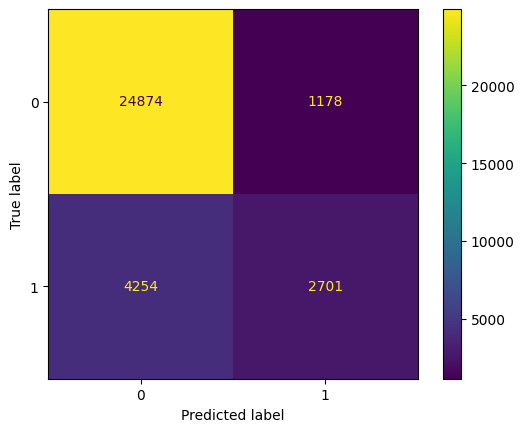

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", conf_matrix)
conf_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                       display_labels=pipe.classes_)
conf_plot.plot()
plt.show()

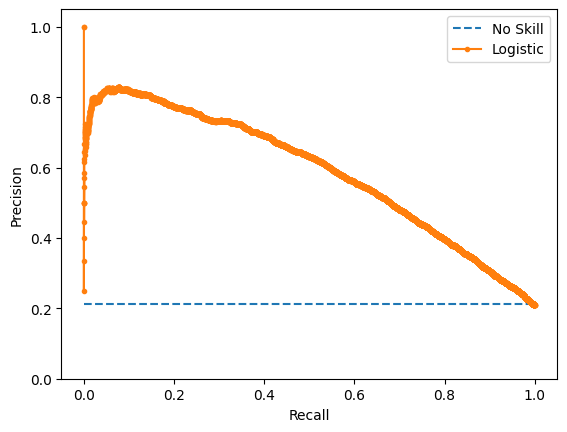

In [24]:
# Plot precision recall curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot

# predict probabilities
y_pred_proba = pipe.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = y_pred_proba[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# Set y to be between 0 and 1
pyplot.ylim([0.0, 1.05])
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

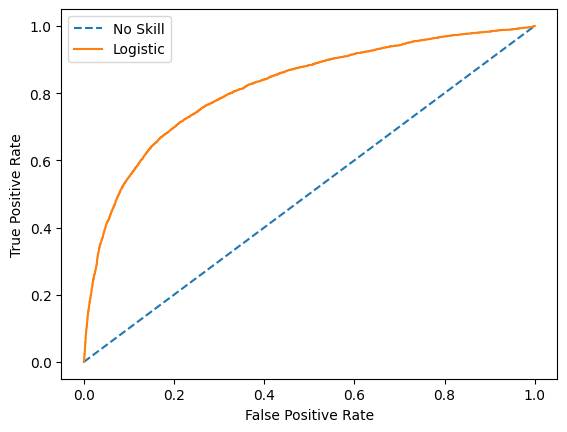

In [22]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
# Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

y_pred_proba = pipe.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = y_pred_proba[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
#  marker='.',
pyplot.plot(fpr, tpr, label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
